In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import joblib

In [2]:
# open the dataset
data = 'clean_data/cleaned_DDoS_and_begnin_traffic_dataset.csv'
df = pd.read_csv(data)

## Train/Test Split, Feature Selection, Scaling,Training and Evaluation

In [3]:
print(df.columns.tolist())

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [4]:
# Separate label (target) and features
X = df.drop(' Label', axis=1)  # all columns except label
y = (df[" Label"] != "BENIGN").astype(int)  # e.g., make malicious=1 if label not benign

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [6]:
# scale only the training set in order to avoid label leakage
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Feature Selection

In [7]:
# Feature selection (top 20)
selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel  = selector.transform(X_test_scaled)
selected_features = X_train.columns[selector.get_support()]

print("Selected features:", selected_features)

Selected features: Index([' Destination Port', ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Fwd IAT Std', 'Bwd IAT Total',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' Average Packet Size',
       ' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
       ' min_seg_size_forward'],
      dtype='object')


/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Train logistic regression

In [8]:
clf_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf_lr.fit(X_train_sel, y_train)
y_pred_lr  = clf_lr.predict(X_test_sel)
y_proba_lr = clf_lr.predict_proba(X_test_sel)[:,1]

In [9]:
print("Logistic Regression results:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression results:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     82632
           1       0.89      0.98      0.93     38989

    accuracy                           0.96    121621
   macro avg       0.94      0.96      0.95    121621
weighted avg       0.96      0.96      0.96    121621

ROC AUC: 0.9946239378044128


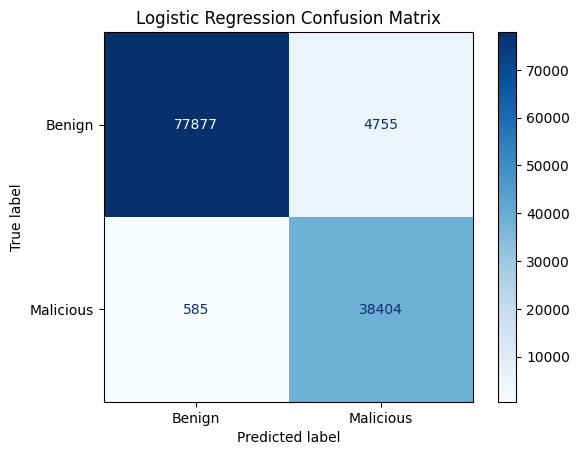

In [10]:
# Confusion Matrix (Logistic Regression)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Benign", "Malicious"])
disp_lr.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [11]:
# Save Logistic Regression Model
joblib.dump(clf_lr, "classifiers/models/logistic_regression_model.joblib")
joblib.dump(scaler, "classifiers/models/minmax_scaler.joblib")
joblib.dump(selector, "classifiers/models/feature_selector.joblib")

['classifiers/models/feature_selector.joblib']

### Train Decision Tree

In [30]:
clf_dt = DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42)
clf_dt.fit(X_train_sel, y_train)
y_pred_dt = clf_dt.predict(X_test_sel)

In [31]:
print("Decision Tree results:")
print(classification_report(y_test, y_pred_dt))

Decision Tree results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82632
           1       1.00      0.99      1.00     38989

    accuracy                           1.00    121621
   macro avg       1.00      1.00      1.00    121621
weighted avg       1.00      1.00      1.00    121621



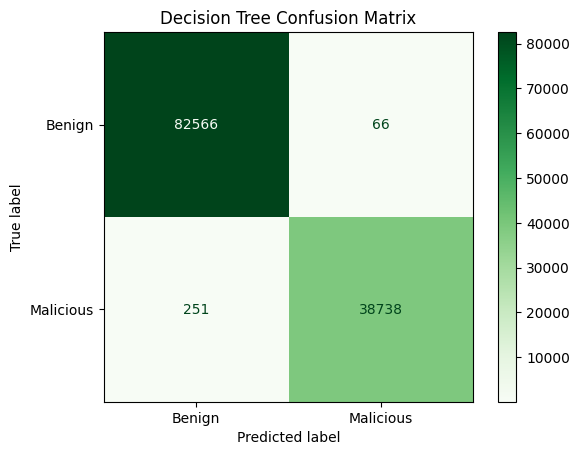

In [32]:
# Confusion Matrix (Decision Tree)
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Benign", "Malicious"])
disp_dt.plot(cmap='Greens', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [33]:
# Save Decision Tree Model
joblib.dump(clf_dt, "classifiers/models/decision_tree_model.joblib")
print("Decision Tree model saved as 'decision_tree_model.joblib'")

Decision Tree model saved as 'decision_tree_model.joblib'


### Interpretation

In [34]:
# Logistic coefficients
for feat, coef in zip(selected_features, clf_lr.coef_[0]):
    print(feat, ":", coef)

 Destination Port : -4.589087785251351
 Fwd Packet Length Mean : -20.803835698076142
Bwd Packet Length Max : -3.6601973683643827
 Bwd Packet Length Min : -2.0416439433944698
 Bwd Packet Length Mean : -2.85601086137593
 Bwd Packet Length Std : 10.59191809365884
 Fwd IAT Std : 17.265842016803077
Bwd IAT Total : -21.0157751497997
 Min Packet Length : 0.14384483978909407
 Max Packet Length : -8.76080614898398
 Packet Length Mean : 1.3509626407142699
 Packet Length Std : -0.0529570353517985
 Packet Length Variance : 22.746346856341436
 PSH Flag Count : 4.519023463767696
 ACK Flag Count : 7.8418896582049635
 URG Flag Count : -2.358935879199254
 Average Packet Size : 7.666667124596935
 Avg Fwd Segment Size : -20.803835698076142
 Avg Bwd Segment Size : -2.856010861384747
 min_seg_size_forward : -15.719342885548613


In [35]:
# Tree feature importances
for feat, imp in zip(selected_features, clf_dt.feature_importances_):
    print(feat, ":", imp)

 Destination Port : 0.009438579553758791
 Fwd Packet Length Mean : 0.6083825267042235
Bwd Packet Length Max : 0.0
 Bwd Packet Length Min : 0.0051253982808191585
 Bwd Packet Length Mean : 5.4050078479729306e-05
 Bwd Packet Length Std : 0.0
 Fwd IAT Std : 0.29978950489049905
Bwd IAT Total : 0.0003469028531832248
 Min Packet Length : 1.0501503784692926e-05
 Max Packet Length : 0.0
 Packet Length Mean : 1.5117835487287908e-14
 Packet Length Std : 0.0
 Packet Length Variance : 8.420396339320104e-05
 PSH Flag Count : 7.244829387803514e-05
 ACK Flag Count : 0.0002294483585982733
 URG Flag Count : 0.0
 Average Packet Size : 0.05296777360121917
 Avg Fwd Segment Size : 0.0005968831920017417
 Avg Bwd Segment Size : 0.021148668040804446
 min_seg_size_forward : 0.0017531106853418369
